# ML-based fruit and vegetable detection app
Author: Andrii Zapukhlyi

## Objective
The primary goal of this project is to address the inefficiency at self-checkout desks, where customers must manually select items without barcodes. By implementing camera-based detection, this solution automates the identification of fruits and vegetables, significantly reducing checkout time and improving the overall customer experience. Additionally, the project aims to develop a mobile app that enables users to easily test the fruit and vegetable recognition model on their smartphones.

## Solution

To address the problem, I trained a YOLOv8 L model to detect and classify fruits and vegetables in images efficiently. 

## Preprocess entire dataset

The dataset, downloaded from <a href="https://www.kaggle.com/datasets/kvnpatel/fruits-vegetable-detection-for-yolov4/data">Kaggle</a>, consists of two folders: train and test, each containing images and labels. To streamline processing, I organized the dataset by creating separate subfolders for images and labels within each folder.

In [2]:
import os
import shutil

def preprocess_files(dir):
    source_dir = dir
    images_dir = os.path.join(source_dir, "images")
    labels_dir = os.path.join(source_dir, "labels")

    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for file in os.listdir(source_dir):
        file_path = os.path.join(source_dir, file)
        
        if os.path.isdir(file_path):
            continue

        if file.endswith(".jpg"):
            shutil.move(file_path, os.path.join(images_dir, file))
        
        elif file.endswith(".txt"):
            shutil.move(file_path, os.path.join(labels_dir, file))

preprocess_files("train")
preprocess_files("test")

## Create YAML file

In [3]:
import yaml

data = {
    'train': '/train/images',
    'val': '/test/images',
    'nc': 14,
    'names': ['banana-bag', 'banana', 'blackberries', 'raspberry', 'lemon-bag', 'lemon', 'grapes-bag', 'grapes', 'tomato-bag', 'tomato', 'apple-bag', 'apple', 'chili-bag', 'chili']
}

yaml_file_path = "data.yaml"

with open(yaml_file_path, 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

The dataset contains 14 classes, with fruits in plastic bags labeled as separate categories. Notably, lemons in the dataset are actually limes (green in color, not yellow).

## Data overview

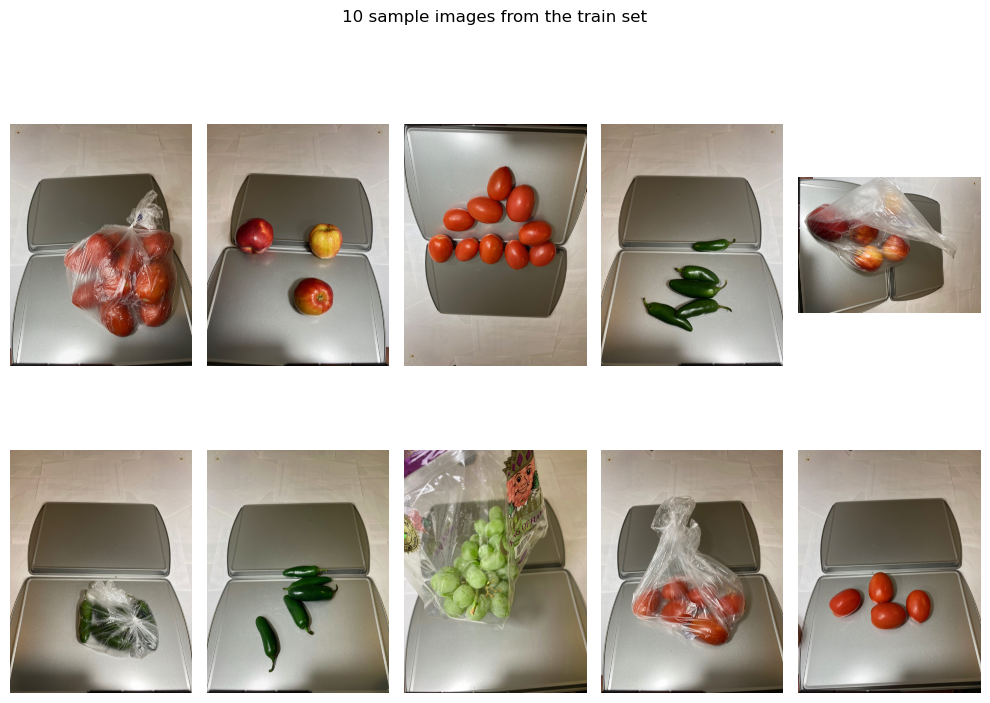

In [76]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image_folder = "train/images/"
image_files = [f for f in os.listdir(image_folder) if f.endswith(('jpg', 'jpeg', 'png', 'bmp'))]
indexes = np.random.choice(range(len(image_files)), 10, replace=False)
fig, axes = plt.subplots(2, 5, figsize=(10, 8))

for idx, ax in zip(indexes, axes.flatten()):
    img_path = os.path.join(image_folder, image_files[idx])
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off') 

plt.suptitle("10 sample images from the train set")
plt.tight_layout() 
plt.show()

All images in the dataset were manually captured by *kvnpatel.kp@gmail.com* using an iPhone 11. The entire dataset maintains consistency with a single camera angle, lighting condition, and background.

## YOLO algorithm

I trained the YOLOv8 Large model on the cloud with GPU acceleration, using the following hyperparameters:
- Number of iterations: 100
- Image size: 640
- Batch size: 16

The model was trained for approximately 7 hours using a Tesla P100 16GB GPU.
After training, I exported the weights of the best-performing model and used them for making predictions.

In [ ]:
from ultralytics import YOLO

model = YOLO('trained_YOLO/weights/best.pt')

## The last 10 iterations of the training

In [72]:
import pandas as pd
pd.read_csv("trained_YOLO/results.csv").tail(10)

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
90,91,22827.8,0.24874,0.14381,0.81896,0.98046,0.99345,0.99116,0.96404,0.29564,0.17136,0.83036,0.000061,0.000061,0.000061
91,92,23077.6,0.23853,0.13791,0.81736,0.98303,0.99406,0.99146,0.96621,0.28975,0.16830,0.83299,0.000055,0.000055,0.000055
92,93,23327.5,0.23150,0.13585,0.81467,0.98246,0.99273,0.99194,0.96607,0.28629,0.16599,0.83187,0.000050,0.000050,0.000050
93,94,23576.5,0.22678,0.13143,0.81543,0.98472,0.99287,0.99219,0.96605,0.28462,0.16400,0.82926,0.000044,0.000044,0.000044
94,95,23826.0,0.22345,0.13158,0.81131,0.98382,0.99461,0.99200,0.96593,0.28697,0.15855,0.83336,0.000039,0.000039,0.000039
95,96,24075.9,0.21786,0.13113,0.81011,0.98298,0.99455,0.99152,0.96782,0.27867,0.15761,0.82808,0.000033,0.000033,0.000033
96,97,24326.4,0.21762,0.12799,0.81106,0.98380,0.99466,0.99162,0.96810,0.27548,0.15500,0.82275,0.000028,0.000028,0.000028
97,98,24576.7,0.21143,0.12714,0.80608,0.98323,0.99453,0.99221,0.97071,0.26954,0.15159,0.81958,0.000022,0.000022,0.000022
98,99,24828.2,0.20952,0.12333,0.80879,0.98277,0.99448,0.99222,0.97063,0.26741,0.15122,0.81814,0.000017,0.000017,0.000017
99,100,25079.2,0.20620,0.12222,0.80386,0.98431,0.99440,0.99241,0.97110,0.26644,0.14894,0.81762,0.000011,0.000011,0.000011


## YOLO evaluating
<img height="700" width = "850" src="trained_YOLO/confusion_matrix.png">
<p>Confusion Matrix: The model's most common misclassifications involved labeling lemons and grapes as background.</p>
<img height="700" width = "850" src="trained_YOLO/F1_curve.png">
<p>F1-Confidence Curve: The model achieved an F1-score of 0.99 for all classes, with a confidence threshold of 0.771.</p>
<img height="700" width = "850" src="trained_YOLO/results.png">
<p>Training Metrics and Loss trends: Throughout training, losses consistently decreased for both the training and validation sets. The model achieved near-perfect scores in precision, recall, mAP@50, and mAP@50-95, indicating excellent performance.</p>
<img height="700" width = "850" src="trained_YOLO/val_batch0_pred.jpg">
<p>Validation Predictions: For the first batch of the validation set, the model accurately predicted fruits with a probability exceeding 0.8.</p>

In [8]:
val = model.val(device = "mps")
val.results_dict

Ultralytics 8.3.33 🚀 Python-3.10.15 torch-2.5.1 MPS (Apple M2)


Fontconfig warning: ignoring UTF-8: not a valid region tag
val: Scanning /Users/andrik/DATA/Development/ML/DeepLearning/fruits_vegetable_detection/test/labels.cache... 650 images, 0 backgrounds, 0 corrupt: 100%|██████████| 650/650 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [02:09<00:00,  3.16s/it]


                   all        650        788      0.985      0.994      0.992      0.972
            banana-bag         58         58      0.996          1      0.995      0.982
                banana         52         67      0.997          1      0.995      0.989
          blackberries         23         23      0.992          1      0.995      0.982
             raspberry         26         26      0.993          1      0.995      0.989
             lemon-bag         53         53      0.996          1      0.995      0.983
                 lemon         50         79      0.908      0.962      0.969      0.934
            grapes-bag         49         49      0.997          1      0.995       0.97
                grapes         47         82      0.973      0.988      0.992      0.924
            tomato-bag         50         50      0.996          1      0.995      0.989
                tomato         44         73      0.984      0.986       0.99      0.949
             apple-ba

{'metrics/precision(B)': 0.9853475319053059,
 'metrics/recall(B)': 0.9943755418849661,
 'metrics/mAP50(B)': 0.9924928915255341,
 'metrics/mAP50-95(B)': 0.9720437888891732,
 'fitness': 0.9740886991528093}

In [29]:
p = val.results_dict["metrics/precision(B)"]
r = val.results_dict["metrics/recall(B)"]
f1 = (2*p*r)/(p+r)
print(f"F1 score: {f1}")

F1 score: 0.9898409519544259


YOLOv8-Large achieved the following results on the validation dataset:
- Precision: 0.99
- Recall: 0.99
- mAP50: 0.99
- mAP50-95: 0.97
- F1-score: 0.99

These results are exceptional. However, the real question is whether the model will perform as well on data from a different distribution. Since both the training and validation datasets have the same background, lighting, and other conditions, the model's performance may not generalize as effectively to new, unseen environments with different conditions.

## Model testing 

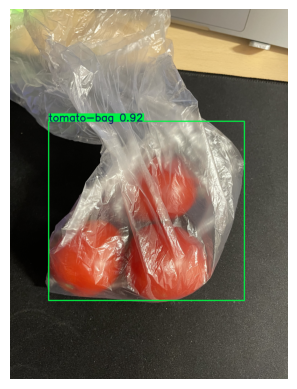

In [16]:
import cv2

link = "test_image.heic"

prediction = model.predict(link, device="mps", imgsz=640, verbose = False)
img = prediction[0].plot()
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

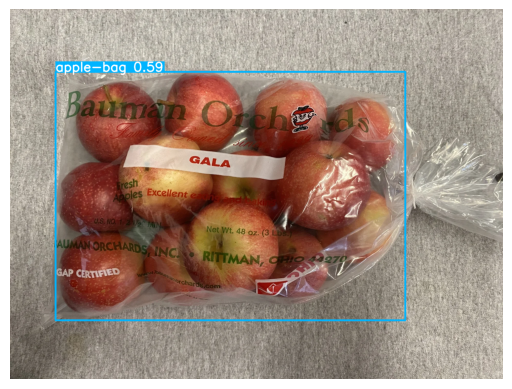

In [10]:
import cv2

link = "test_image2.webp"

prediction = model.predict(link, device="mps", imgsz=640, verbose = False)
img = prediction[0].plot()
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

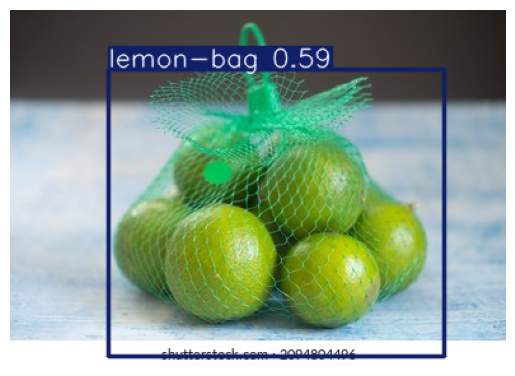

In [59]:
import cv2

link = "test_image3.jpg"

prediction = model.predict(link, device="mps", imgsz=640, verbose = False)
img = prediction[0].plot()
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

The first image was taken by me, while the second and third images were sourced from the internet. The prediction images above demonstrate that the model is capable of accurately classifying fruits and vegetables from a different distribution, indicating its generalization ability.

## Conclusion

The trained YOLO model achieved excellent accuracy in detecting and classifying fruits and vegetables, offering a promising solution for self-checkout systems. By automating the identification process, it significantly reduces checkout time and improves the customer experience. The model's strong performance on diverse test data highlights its potential for real-world applications.